In [ ]:
import math as ma
import numpy as np
from numpy import linalg
from scipy import interpolate
from scipy.interpolate import lagrange

from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 5.0)

# Основные функции

In [ ]:
def Theta_factorised(e, x, y, X, Y):
    theta = 0
    Y_y = np.dot(np.linalg.inv(Y), y)
    A = np.linalg.cholesky(Y).T
    x = x + e[1]
    exp1 = np.exp(np.pi*np.dot(y.T, Y_y))
    
    def v(n):
        return ma.sqrt(np.pi) * (A.dot(n) + A.dot(Y_y))
    
    c = - Y_y
    R = 10
    left2 = c[1] - R/ma.sqrt(np.pi)/A[1][1]
    right2 = c[1] + R/ma.sqrt(np.pi)/A[1][1]
    if A[0][1] > 0:
        left1 = c[0] - R/ma.sqrt(np.pi)/A[0][0] - A[0][1] * (right2 - c[1])/A[0][0]
        right1 = c[0] + R/ma.sqrt(np.pi)/A[0][0] - A[0][1] * (left2 - c[1])/A[0][0]
    else:
        left1 = c[0] - R/ma.sqrt(np.pi)/A[0][0] - A[0][1] * (left2 - c[1])/A[0][0]
        right1 = c[0] + R/ma.sqrt(np.pi)/A[0][0] - A[0][1] * (right2 - c[1])/A[0][0]
    for n2 in range(int(left2), int(right2)):
        for n1 in range(int(left1), int(right1)):
            n = np.array([n1,n2]) + e[0]
            param1 = np.pi*( 0.5 * n.T @ X @ n + n.T @ x) 
            param2 = np.pi*np.dot(y.T, Y_y) - np.dot(v(n).T, v(n))
            exp2 = np.exp(2.j*param1 + param2)
            theta += exp2 #* np.exp(- np.dot(v(n).T, v(n)))
        #print(np.exp(- np.dot(v(n).T, v(n)) + np.pi*np.dot(y.T, Y_y)))
            
    return theta


def U(x):
    return np.array([[[x[0], 0.5], [0.5, -x[0]]], [[x[1], x[2]], [x[2], x[1]]]])


def f_inf(n, m, x):
    R = U(x)
    f = np.array([-1/(2*n) * (np.array([R[0][0][1], R[0][1][1]]) + np.array([R[0][1][1], R[0][0][1]]) + np.array([m - n, m - n])),\
-1/(2*n) * (np.array([R[1][0][1], R[1][1][1]]) - np.array([R[1][1][1], R[1][0][1]]))])
    return f


def Grad_Theta(e, x, y, X, Y, k):
    theta = 0
    Y_y = np.dot(np.linalg.inv(Y), y)
    exp1 = np.exp(np.pi*np.dot(y.T, Y_y))
    A = np.linalg.cholesky(Y).T
    x = x + e[1]
    
    def v(n):
        return np.sqrt(np.pi) * (A.dot(n) + A.dot(Y_y))
    
    c = -Y_y 
    R = 10
    left2 = c[1] - R/np.sqrt(np.pi)/A[1][1]
    right2 = c[1] + R/np.sqrt(np.pi)/A[1][1]
    if A[0][1] > 0:
        left1 = c[0] - R/np.sqrt(np.pi)/A[0][0] - A[0][1] * (right2 - c[1])/A[0][0]
        right1 = c[0] + R/np.sqrt(np.pi)/A[0][0] - A[0][1] * (left2 - c[1])/A[0][0]
    else:
        left1 = c[0] - R/np.sqrt(np.pi)/A[0][0] - A[0][1] * (left2 - c[1])/A[0][0]
        right1 = c[0] + R/np.sqrt(np.pi)/A[0][0] - A[0][1] * (right2 - c[1])/A[0][0]
    for n2 in range(int(left2), int(right2)):
        for n1 in range(int(left1), int(right1)):
            n = np.array([n1,n2]) + e[0]
            param1 = np.pi*( 0.5 * n.T @ X @ n + n.T @ x)
            param2 = - np.dot(v(n).T, v(n)) + np.pi*np.dot(y.T, Y_y)
            exp2 = np.exp(2.j*param1 + param2)
            #np.sin(2*np.pi*( 0.5*(np.dot((n - Y_y).T, X.dot(n - Y_y))) + np.dot((n - Y_y).T, x)))*1j
            r = 2*np.pi*1j*n
            for i in range(len(k)):  
                exp2 *= r[k[i]]
            theta += exp2 #* np.exp(- np.dot(v(n).T, v(n)) + np.pi*np.dot(y.T, Y_y))
        #print(theta)
    return theta

def x_u(u1, u2, e, n, m, x, j = 1):
    e1 = np.array([[0.5, 0], [0.5, 0]])
    e2 = np.array([[0, 0.5], [0.5, 0.5]])
    e3 = np.array([[0.5, 0], [0, 0.5]])
    e4 = np.array([[0, 0.5], [0, 0]])
    
    R = U(x)
    O1 = Theta_factorised(e1, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j *u2]), R[0], R[1])
    O2 = Theta_factorised(e2, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j *u2]), R[0], R[1])
    O_plus = Theta_factorised(e2, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j *u2]) + f_inf(n, m, x)[1], R[0], R[1])
    O_minus = Theta_factorised(e1, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j *u2]) - f_inf(n, m, x)[1], R[0], R[1])
    
    Oc1_plus = Theta_factorised(e3, f_inf(n, m, x)[0], f_inf(n, m, x)[1], R[0], R[1])
    Oc2_plus = Theta_factorised(e4, f_inf(n, m, x)[0], f_inf(n, m, x)[1], R[0], R[1])
    Oc1 = Theta_factorised(e3, np.array([0,0]), np.array([0,0]), R[0], R[1])
    Oc2 = Theta_factorised(e4, np.array([0,0]), np.array([0,0]), R[0], R[1])
    
    const = -Oc1_plus*Oc2_plus/Oc1/Oc2
    #print(const)
    
    return O1*O2/O_plus/O_minus * const

def Grad_x(u1, u2, e_1, n, m, x, k, j = 1):
    e1 = np.array([[0.5, 0], [0.5, 0]])
    e2 = np.array([[0, 0.5], [0.5, 0.5]])
    R = U(x)
    x_ = x_u(u1, u2, e_1, n, m, x, j) 
    O1 = Theta_factorised(e1, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1])
    O2 = Theta_factorised(e2, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1])
    O_plus = Theta_factorised(e2, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) + f_inf(n, m, x)[1], R[0], R[1])
    O_minus = Theta_factorised(e1, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) - f_inf(n, m, x)[1], R[0], R[1])
    O1_grad = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k)
    O2_grad = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k)
    O_plus_grad = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                             f_inf(n, m, x)[1], R[0], R[1], k)
    O_minus_grad = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                              f_inf(n, m, x)[1], R[0], R[1], k)
    
    A = O1_grad/O1 + O2_grad/O2 - O_plus_grad/O_plus - O_minus_grad/O_minus
    
    return x_ * A

def Grad2_x(u1, u2, e_1, n, m, x, k, j = 1):
    e1 = np.array([[0.5, 0], [0.5, 0]])
    e2 = np.array([[0, 0.5], [0.5, 0.5]])
    R = U(x)
    x_ = x_u(u1, u2, e_1, n, m, x, j)
    #x1_1 = Grad_x(u1, u2, e1, n, m, x, k[0:1])
    x1_2 = Grad_x(u1, u2, e_1, n, m, x, k[1:2], j)
    
    O1 = Theta_factorised(e1, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1])
    O2 = Theta_factorised(e2, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1])
    O_plus = Theta_factorised(e2, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) + f_inf(n, m, x)[1], R[0], R[1])
    O_minus = Theta_factorised(e1, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) - f_inf(n, m, x)[1], R[0], R[1])

    O1_grad_1 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[:1])
    O2_grad_1 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[:1])
    O_plus_grad_1 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                             f_inf(n, m, x)[1], R[0], R[1], k[:1])
    O_minus_grad_1 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                              f_inf(n, m, x)[1], R[0], R[1], k[:1])
    
    O1_grad_2 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[1:2])
    O2_grad_2 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[1:2])
    O_plus_grad_2 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                             f_inf(n, m, x)[1], R[0], R[1], k[1:2])
    O_minus_grad_2 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                              f_inf(n, m, x)[1], R[0], R[1], k[1:2])
    
    O1_grad2 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[:2])
    O2_grad2 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[:2])
    O_plus_grad2 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                             f_inf(n, m, x)[1], R[0], R[1], k[:2])
    O_minus_grad2 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                              f_inf(n, m, x)[1], R[0], R[1], k[:2])
    
    
    A_1 = O1_grad_1/O1 + O2_grad_1/O2 - O_plus_grad_1/O_plus - O_minus_grad_1/O_minus
    B_12 = O1_grad2/O1 - O1_grad_1*O1_grad_2/O1**2 + O2_grad2/O2 - O2_grad_1*O2_grad_2/O2**2 -\
    O_plus_grad2/O_plus - O_minus_grad2/O_minus +\
    O_plus_grad_1*O_plus_grad_2/O_plus**2 + O_minus_grad_1*O_minus_grad_2/O_minus**2
    
    return x1_2 * A_1 + x_ * B_12

def Grad3_x(u1, u2, e_1, n, m, x, k, j = 1):
    e1 = np.array([[0.5, 0], [0.5, 0]])
    e2 = np.array([[0, 0.5], [0.5, 0.5]])
    R = U(x)
    x_ = x_u(u1, u2, e_1, n, m, x, j)
    x1_2 = Grad_x(u1, u2, e_1, n, m, x, k[1:2], j)
    x1_3 = Grad_x(u1, u2, e_1, n, m, x, k[2:3], j)
    x2_23 = Grad2_x(u1, u2, e_1, n, m, x, k[1:3], j)
    
    O1 = Theta_factorised(e1, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1])
    O2 = Theta_factorised(e2, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1])
    O_plus = Theta_factorised(e2, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) + f_inf(n, m, x)[1], R[0], R[1])
    O_minus = Theta_factorised(e1, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) - f_inf(n, m, x)[1], R[0], R[1])

    O1_grad_1 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[:1])
    O2_grad_1 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[:1])
    O_plus_grad_1 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                             f_inf(n, m, x)[1], R[0], R[1], k[:1])
    O_minus_grad_1 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                              f_inf(n, m, x)[1], R[0], R[1], k[:1])
    
    O1_grad_2 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[1:2])
    O2_grad_2 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[1:2])
    O_plus_grad_2 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                             f_inf(n, m, x)[1], R[0], R[1], k[1:2])
    O_minus_grad_2 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                              f_inf(n, m, x)[1], R[0], R[1], k[1:2])
    
    O1_grad_3 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[2:3])
    O2_grad_3 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[2:3])
    O_plus_grad_3 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                             f_inf(n, m, x)[1], R[0], R[1], k[2:3])
    O_minus_grad_3 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                              f_inf(n, m, x)[1], R[0], R[1], k[2:3])
    
    O1_grad2_12 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[:2])
    O2_grad2_12 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[:2])
    O_plus_grad2_12 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                             f_inf(n, m, x)[1], R[0], R[1], k[:2])
    O_minus_grad2_12 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                              f_inf(n, m, x)[1], R[0], R[1], k[:2])
    
    O1_grad2_13 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], [k[0], k[2]])
    O2_grad2_13 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], [k[0], k[2]])
    O_plus_grad2_13 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                             f_inf(n, m, x)[1], R[0], R[1], [k[0], k[2]])
    O_minus_grad2_13 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                              f_inf(n, m, x)[1], R[0], R[1], [k[0], k[2]])
    
    O1_grad2_23 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[1:])
    O2_grad2_23 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[1:])
    O_plus_grad2_23 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                             f_inf(n, m, x)[1], R[0], R[1], k[1:])
    O_minus_grad2_23 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                              f_inf(n, m, x)[1], R[0], R[1], k[1:])
    
    O1_grad3 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k)
    O2_grad3 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k)
    O_plus_grad3 = Grad_Theta(e2, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                             f_inf(n, m, x)[1], R[0], R[1], k)
    O_minus_grad3 = Grad_Theta(e1, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                              f_inf(n, m, x)[1], R[0], R[1], k)
    
    
    A_1 = O1_grad_1/O1 + O2_grad_1/O2 - O_plus_grad_1/O_plus - O_minus_grad_1/O_minus
    B_12 = O1_grad2_12/O1 - O1_grad_1*O1_grad_2/O1**2 + O2_grad2_12/O2 - O2_grad_1*O2_grad_2/O2**2 -\
    O_plus_grad2_12/O_plus - O_minus_grad2_12/O_minus +\
    O_plus_grad_1*O_plus_grad_2/O_plus**2 + O_minus_grad_1*O_minus_grad_2/O_minus**2
    B_13 = O1_grad2_13/O1 - O1_grad_1*O1_grad_3/O1**2 + O2_grad2_13/O2 - O2_grad_1*O2_grad_3/O2**2 -\
    O_plus_grad2_13/O_plus - O_minus_grad2_13/O_minus +\
    O_plus_grad_1*O_plus_grad_3/O_plus**2 + O_minus_grad_1*O_minus_grad_3/O_minus**2

    
    C_123 = (O1_grad3/O1 - O1_grad2_12*O1_grad_3/O1**2 - O1_grad2_13*O1_grad_2/O1**2 - O1_grad_1*O1_grad2_23/O1**2 \
               + 2*O1_grad_1*O1_grad_2*O1_grad_3/O1**3) +\
            (O2_grad3/O2 - O2_grad2_12*O2_grad_3/O2**2 - O2_grad2_13*O2_grad_2/O2**2 - O2_grad_1*O2_grad2_23/O2**2 \
               + 2*O2_grad_1*O2_grad_2*O2_grad_3/O2**3) -\
    (O_plus_grad3/O_plus - O_plus_grad2_12*O_plus_grad_3/O_plus**2 - O_plus_grad2_13*O_plus_grad_2/O_plus**2 -\
     O_plus_grad_1*O_plus_grad2_23/O_plus**2 + 2*O_plus_grad_1*O_plus_grad_2*O_plus_grad_3/O_plus**3) -\
    (O_minus_grad3/O_minus - O_minus_grad2_12*O_minus_grad_3/O_minus**2 - O_minus_grad2_13*O_minus_grad_2/O_minus**2 -\
     O_minus_grad_1*O_minus_grad2_23/O_minus**2 + 2*O_minus_grad_1*O_minus_grad_2*O_minus_grad_3/O_minus**3)
    
    return x2_23 * A_1 + x1_2 * B_13 + x1_3 * B_12 + x_ * C_123

def P_u(u1, u2, e1, n, m, x, j=1):
    e = np.array([[0.5, 0.5],[0.5, 0]])
    R = U(x)
    P = 1
    B = Theta_factorised(e, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) + f_inf(n, m, x)[1], R[0], R[1]) /\
    Theta_factorised(e, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) - f_inf(n, m, x)[1], R[0], R[1])
    for i in range(n):
        P *= -B
    mul = np.array([u1 + 1j*u2, (-1)**(j+1) * u1 + (-1)**j * u2* 1j]) @ np.array([1, -1])
    return P * np.exp(2.j*np.pi*mul)

def Grad_P(u1, u2, e1, n, m, x, k, j=1):
    e = np.array([[0.5, 0.5],[0.5, 0]])
    R = U(x)
    O = Theta_factorised(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1])
    O_plus = Theta_factorised(e, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) + f_inf(n, m, x)[1], R[0], R[1])
    O_minus = Theta_factorised(e, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) - f_inf(n, m, x)[1], R[0], R[1])
    O_grad = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[:1])
    O_plus_grad = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) + f_inf(n, m, x)[1], R[0], R[1], k[:1])
    O_minus_grad = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) - f_inf(n, m, x)[1], R[0], R[1], k[:1])

    A = n*(O_plus_grad/O_plus - O_minus_grad/O_minus) + 2j*np.pi*np.array([1,-1])[k[0]]
    
    return P_u(u1, u2, e, n, m, x, j) * A
def Grad2_P(u1, u2, e1, n, m, x, k, j=1):
    e = np.array([[0.5, 0.5],[0.5, 0]])
    R = U(x)
    P = P_u(u1, u2, e1, n, m, x, j)
    P1 = Grad_P(u1, u2, e1, n, m, x, k[1:2], j)
    O = Theta_factorised(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1])
    O_plus = Theta_factorised(e, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) + f_inf(n, m, x)[1], R[0], R[1])
    O_minus = Theta_factorised(e, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) - f_inf(n, m, x)[1], R[0], R[1])
    
    O_grad_1 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[:1])
    O_plus_grad_1 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                             f_inf(n, m, x)[1], R[0], R[1], k[:1])
    O_minus_grad_1 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                              f_inf(n, m, x)[1], R[0], R[1], k[:1])
    O_grad_2 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[1:2])
    O_plus_grad_2 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                             f_inf(n, m, x)[1], R[0], R[1], k[1:2])
    O_minus_grad_2 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                              f_inf(n, m, x)[1], R[0], R[1], k[1:2])
    
    O_grad2 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[:2])
    O_plus_grad2 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                              f_inf(n, m, x)[1], R[0], R[1], k[:2])
    O_minus_grad2 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                               f_inf(n, m, x)[1], R[0], R[1], k[:2])
    
    A = n*(O_plus_grad_1/O_plus - O_minus_grad_1/O_minus) + 2j*np.pi*np.array([1,-1])[k[0]]
    B_12 = n*(O_plus_grad2/O_plus - O_plus_grad_1*O_plus_grad_2/O_plus**2 - O_minus_grad2/O_minus +\
              O_minus_grad_1*O_minus_grad_2/O_minus**2)
    
    return P1 * A + P * B_12
def Grad3_P(u1, u2, e1, n, m, x, k, j=1):
    e = np.array([[0.5, 0.5],[0.5, 0]])
    R = U(x)
    P = P_u(u1, u2, e1, n, m, x, j)
    P1_2 = Grad_P(u1, u2, e1, n, m, x, k[1:2], j)
    P1_3 = Grad_P(u1, u2, e1, n, m, x, k[2:3], j)
    P2_23 = Grad2_P(u1, u2, e1, n, m, x, k[1:], j)
    O = Theta_factorised(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1])
    O_plus = Theta_factorised(e, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) + f_inf(n, m, x)[1], R[0], R[1])
    O_minus = Theta_factorised(e, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) - f_inf(n, m, x)[1], R[0], R[1])
    
    O_grad_1 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[:1])
    O_plus_grad_1 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                             f_inf(n, m, x)[1], R[0], R[1], k[:1])
    O_minus_grad_1 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                              f_inf(n, m, x)[1], R[0], R[1], k[:1])
    O_grad_2 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[1:2])
    O_plus_grad_2 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                             f_inf(n, m, x)[1], R[0], R[1], k[1:2])
    O_minus_grad_2 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                              f_inf(n, m, x)[1], R[0], R[1], k[1:2])
    O_grad_3 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[2:])
    O_plus_grad_3 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                             f_inf(n, m, x)[1], R[0], R[1], k[2:])
    O_minus_grad_3 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                              f_inf(n, m, x)[1], R[0], R[1], k[2:])
    
    O_grad2_12 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[:2])
    O_plus_grad2_12 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                              f_inf(n, m, x)[1], R[0], R[1], k[:2])
    O_minus_grad2_12 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                               f_inf(n, m, x)[1], R[0], R[1], k[:2])
    O_grad2_13 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], [k[0], k[2]])
    O_plus_grad2_13 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                              f_inf(n, m, x)[1], R[0], R[1], [k[0], k[2]])
    O_minus_grad2_13 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                               f_inf(n, m, x)[1], R[0], R[1], [k[0], k[2]])
    O_grad2_23 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k[1:])
    O_plus_grad2_23 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) +\
                              f_inf(n, m, x)[1], R[0], R[1], k[1:])
    O_minus_grad2_23 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) -\
                               f_inf(n, m, x)[1], R[0], R[1], k[1:])
    
    O_plus_grad3 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) + f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) + f_inf(n, m, x)[1], R[0], R[1], k)
    O_minus_grad3 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]) - f_inf(n, m, x)[0], np.array([u2, (-1)**j * u2]) - f_inf(n, m, x)[1], R[0], R[1], k)
    O_grad3 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1], k)
    
    A = n*(O_plus_grad_1/O_plus - O_minus_grad_1/O_minus) + 2j*np.pi*np.array([1,-1])[k[0]]
    B_12 = n*(O_plus_grad2_12/O_plus - O_minus_grad2_12/O_minus -\
    O_plus_grad_1*O_plus_grad_2/O_plus**2 + O_minus_grad_1*O_minus_grad_2/O_minus**2)
    B_13 = n*(O_plus_grad2_13/O_plus - O_minus_grad2_13/O_minus -\
    O_plus_grad_1*O_plus_grad_3/O_plus**2 + O_minus_grad_1*O_minus_grad_3/O_minus**2)
    C_123 = n*((O_plus_grad3/O_plus - O_plus_grad2_12*O_plus_grad_3/O_plus**2 - O_plus_grad2_13*O_plus_grad_2/O_plus**2 -\
     O_plus_grad_1*O_plus_grad2_23/O_plus**2 + 2*O_plus_grad_1*O_plus_grad_2*O_plus_grad_3/O_plus**3) -\
    (O_minus_grad3/O_minus - O_minus_grad2_12*O_minus_grad_3/O_minus**2 - O_minus_grad2_13*O_minus_grad_2/O_minus**2 -\
     O_minus_grad_1*O_minus_grad2_23/O_minus**2 + 2*O_minus_grad_1*O_minus_grad_2*O_minus_grad_3/O_minus**3))
    
    return P2_23 * A + P1_2 * B_13 + P1_3 * B_12 + P * C_123




In [ ]:
def c_x(u1, u2, e, n, m, x, j=1):
    R = U(x)
    O_1 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j *u2]), R[0], R[1], [0])
    O_2 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j *u2]), R[0], R[1], [1])
    x_1 = Grad_x(u1, u2, e, n, m, x, [0], j)
    x_2 = Grad_x(u1, u2, e, n, m, x, [1], j)
    P_1 = Grad_P(u1, u2, e, n, m, x, [0], j)
    P_2 = Grad_P(u1, u2, e, n, m, x, [1], j)
    
    x_11 = Grad2_x(u1, u2, e, n, m, x, [0,0], j)
    x_12 = Grad2_x(u1, u2, e, n, m, x, [0,1], j)
    x_21 = x_12 #Grad2_x(u1, u2, e, n, m, x, [1,0], j)
    x_22 = Grad2_x(u1, u2, e, n, m, x, [1,1], j)
    O_11 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j *u2]), R[0], R[1], [0,0])
    O_12 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j *u2]), R[0], R[1], [0,1])
    O_21 = O_12 #Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j *u2]), R[0], R[1], [1,0])
    O_22 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j *u2]), R[0], R[1], [1,1])
    P_11 = Grad2_P(u1, u2, e, n, m, x, [0,0], j)
    P_12 = Grad2_P(u1, u2, e, n, m, x, [0,1], j)
    P_21 = P_12 #Grad2_P(u1, u2, e, n, m, x, [1,0])
    P_22 = Grad2_P(u1, u2, e, n, m, x, [1,1], j)
    
    x_111 = Grad3_x(u1, u2, e, n, m, x, [0,0,0], j)
    x_112 = Grad3_x(u1, u2, e, n, m, x, [0,0,1], j)
    x_121 = Grad3_x(u1, u2, e, n, m, x, [0,1,0], j)
    x_122 = Grad3_x(u1, u2, e, n, m, x, [0,1,1], j)
    x_211 = x_121 #Grad3_x(u1, u2, e, n, m, x, [1,0,0])
    x_212 = x_122 #Grad3_x(u1, u2, e, n, m, x, [1,0,1])
    x_221 = Grad3_x(u1, u2, e, n, m, x, [1,1,0], j)
    x_222 = Grad3_x(u1, u2, e, n, m, x, [1,1,1], j)
    O_111 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j *u2]), R[0], R[1], [0,0,0])
    O_112 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j *u2]), R[0], R[1], [0,0,1])
    O_121 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j *u2]), R[0], R[1], [0,1,0])
    O_122 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j *u2]), R[0], R[1], [0,1,1])
    O_211 = O_121 #Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j *u2]), R[0], R[1], [1,0,0])
    O_212 = O_122 #Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j *u2]), R[0], R[1], [1,0,1])
    O_221 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j *u2]), R[0], R[1], [1,1,0])
    O_222 = Grad_Theta(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j *u2]), R[0], R[1], [1,1,1])
    P_111 = Grad3_P(u1, u2, e, n, m, x, [0,0,0], j)
    P_112 = Grad3_P(u1, u2, e, n, m, x, [0,0,1], j)
    P_121 = Grad3_P(u1, u2, e, n, m, x, [0,1,0], j)
    P_122 = Grad3_P(u1, u2, e, n, m, x, [0,1,1], j)
    P_211 = P_121 #Grad3_P(u1, u2, e, n, m, x, [1,0,0])
    P_212 = P_122 #Grad3_P(u1, u2, e, n, m, x, [1,0,1])
    P_221 = Grad3_P(u1, u2, e, n, m, x, [1,1,0], j)
    P_222 = Grad3_P(u1, u2, e, n, m, x, [1,1,1], j)
    
    znam = (O_2*x_1 - O_1*x_2)
    #print(znam)
    P1 = (O_2*P_1 - O_1*P_2) / znam
    bask_P = O_2*(O_21*P_1 - O_11*P_2 + O_2*P_11 - O_1*P_21) - O_1*(O_22*P_1 - O_12*P_2 + O_2*P_12 - O_1*P_22)
    bask_x = O_2*(O_21*x_1 - O_11*x_2 + O_2*x_11 - O_1*x_21) - O_1*(O_22*x_1 - O_12*x_2 + O_2*x_12 - O_1*x_22)
    #print(O_22*x_1 - O_12*x_2 + O_2*x_12 - O_1*x_22)
    P2 = (bask_P - P1*bask_x) / (znam)**2
    bask_P_1 = O_2*(O_211*P_1 + O_21*P_11 - O_111*P_2 - O_11*P_21 + O_21*P_11 + O_2*P_111 - O_11*P_21 - O_1*P_211) -\
    O_1*(O_221*P_1 + O_22*P_11 - O_121*P_2 - O_12*P_21 + O_21*P_12 + O_2*P_121 - O_11*P_22 - O_1*P_221) +\
    O_21*(O_21*P_1 - O_11*P_2 + O_2*P_11 - O_1*P_21) - O_11*(O_22*P_1 - O_12*P_2 + O_2*P_12 - O_1*P_22)
    bask_P_2 = O_2*(O_212*P_1 + O_21*P_12 - O_112*P_2 - O_11*P_22 + O_22*P_11 + O_2*P_112 - O_12*P_21 - O_1*P_212) -\
    O_1*(O_222*P_1 + O_22*P_12 - O_122*P_2 - O_12*P_22 + O_22*P_12 + O_2*P_122 - O_12*P_22 - O_1*P_222) +\
    O_22*(O_21*P_1 - O_11*P_2 + O_2*P_11 - O_1*P_21) - O_12*(O_22*P_1 - O_12*P_2 + O_2*P_12 - O_1*P_22)
    
    bask_x_1 = O_2*(O_211*x_1 + O_21*x_11 - O_111*x_2 - O_11*x_21 + O_21*x_11 + O_2*x_111 - O_11*x_21 - O_1*x_211) -\
    O_1*(O_221*x_1 + O_22*x_11 - O_121*x_2 - O_12*x_21 + O_21*x_12 + O_2*x_121 - O_11*x_22 - O_1*x_221) +\
    O_21*(O_21*x_1 - O_11*x_2 + O_2*x_11 - O_1*x_21) - O_11*(O_22*x_1 - O_12*x_2 + O_2*x_12 - O_1*x_22)
    bask_x_2 = O_2*(O_212*x_1 + O_21*x_12 - O_112*x_2 - O_11*x_22 + O_22*x_11 + O_2*x_112 - O_12*x_21 - O_1*x_212) -\
    O_1*(O_222*x_1 + O_22*x_12 - O_122*x_2 - O_12*x_22 + O_22*x_12 + O_2*x_122 - O_12*x_22 - O_1*x_222) +\
    O_22*(O_21*x_1 - O_11*x_2 + O_2*x_11 - O_1*x_21) - O_12*(O_22*x_1 - O_12*x_2 + O_2*x_12 - O_1*x_22)
    
    P3 = -3*P2*bask_x/(znam)**2 + (bask_P_1*O_2 - bask_P_2*O_1  \
                          - P1*(bask_x_1*O_2 - bask_x_2*O_1)) / (znam)**3
    #print(P1, P2, P3)
    
    return P1, P2, P3

# Уравнения системы

In [ ]:
def M(u1, u2, e, n, m, x, j=1):
    R = U(x)
    return Theta_factorised(e, np.array([u1, (-1)**(j+1) * u1]), np.array([u2, (-1)**j * u2]), R[0], R[1])

def Abel(e, n, m, x):
    R = U(x)
    return Theta_factorised(e, f_inf(n, m, x)[0], f_inf(n, m, x)[1], R[0], R[1])

def c1(u1, u2, e, n, m, x, edge, j=1):
    C = c_x(u1, u2, e, n, m, x, j)
    return C[1] / C[0]**2 - edge, C[2]/ C[0]**3 - edge**2

def P_x(u1, u2, e, n, m, x, j=1):
    P = P_u(u1, u2, e, n, m, x, j)
    return 0.5*(P + 1/P)

# Метод Ньютона

In [ ]:
def f1(u1, u2, e, n, m, x, edge):
    C = c1(u1, u2, e, n, m, x, edge)
    return Abel(e, n, m, x).real, M(u1, u2, e, n, m, x).real, P_x(u1, u2, e, n, m, x).real - 1/edge, C[0].real, C[1].real

#solve = [0.055, 0.127, 0.33,  1.25, -0.3]

def f(x0):
    a, b, c, u2, u1 = x0
    #print(f1(u1, u2, np.array([[0.5,0.5],[0,0.5]]), 6, 2, [a,b,c], 0.8))
    return f1(u1, u2, np.array([[0.5,0.5],[0,0.5]]), 3, 1, [a,b,c], 0.8)  

init = np.array([0.33,  1.25, -0.3, 0.127, 0.053]) #0.82469941,  1.26863745, -0.31000211,  0.19318941,  0.06886846
norm1 = linalg.norm(f([0.33,  1.25, -0.3, 0.127, 0.053])) #0.33,  1.25, -0.3, 0.127, 0.053
norm2 = 0
i = 0
while norm1 > 1e-3 and i < 20:
    root = optimize.newton(f, init, tol=10, maxiter = 1) 
    norm2 = linalg.norm(f(root))
    a = init
    if norm2 <= norm1:
        t = 0.5
        init = t*init + (1-t)*root
    else:
        if i != 0:
            t = 0.8
            init = t*pre_init + (1-t)*init
        else:
            t = 0.8
            init = t*init + (1-t)*root
    pre_init = a
    norm1 = linalg.norm(f(init))
    i+=1
if i == 20:
    print('Exceed i = 20')
print(norm1)
root

Exceed i = 20
0.7900332698848089


array([ 0.29473328,  1.28169716, -0.25118993,  0.24099779,  0.04464593])

In [ ]:
ff = f(init)
print(init)
print(ff)
print(linalg.norm(ff))

[ 0.32754859  1.25118406 -0.29847725  0.13686833  0.05317669]
(0.0033770762437283774, 0.01676809258399177, 0.10599818984274934, -0.7703311880246149, -0.1386154336957759)
0.7900332698848089


In [ ]:
norm = linalg.norm(f([0.33,  1.25, -0.3, 0.127, 0.053]))
norm

0.8245980620805362

In [ ]:
t = 0.8
t*np.array([0.74880172,  1.36312694, -0.39885233,  0.21179857,  0.06609637]) + (1-t)*root

array([ 0.76322875,  1.37925774, -0.41465675,  0.22900624,  0.07276252])

# Постронение овалов и многочлена

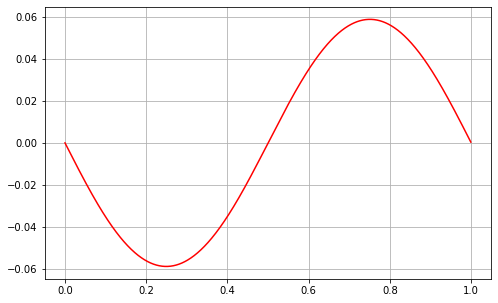

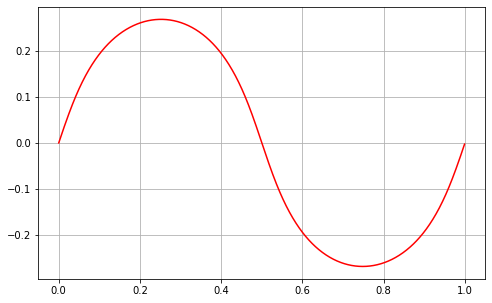

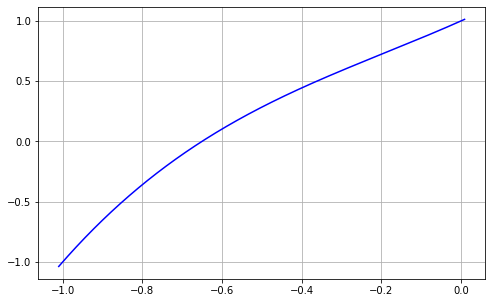

In [ ]:
def f1(e, n, m, x, edge):
    return Abel(e, n, m, x).real
def f(x0):
    a,b,c = x0
    return f1(np.array([[0.5,0.5],[0,0.5]]), 3, 1, [a,b,c], 0.8)
root1 = optimize.newton(f, omega)
#root1 = optimize.newton(f, [4.6031398 ,  1.24999866, -0.14115106])
#root1 = optimize.newton(f, (2, 5, -1))
#root1


def f1(u1, u2, e, n, m, x, edge):
    return M(u1, u2, e, n, m, x, j=0).real

root2 = []

e = np.array([[0.5,0.5],[0,0.5]])
R = U(root1)
#root2.append([0, 0])  #[0.5, -0.02]
for i in range(1000):
    if i == 0:
        a, b = 0, 0
    else:
        a = i/999
        b = root2[i-1][1]
        g1 = Grad_Theta(e, np.array([a, -a]), np.array([b, b]), R[0], R[1], [0])
        g2 = Grad_Theta(e, np.array([a, -a]), np.array([b, b]), R[0], R[1], [1])
        b += (g2.real - g1.imag)/(g1.real - g2.real)

    def f(x0):
        return f1(a, x0, np.array([[0.5,0.5],[0,0.5]]), 3, 1, root1, 0.8) #8,2
    r = optimize.newton(f, b)
    root2.append([a, r])
#root2

xx = [root2[i][0] for i in range(len(root2))]
yy = [root2[i][1] for i in range(len(root2))]
#zz = [O[i] for i in range(len(root2)-1)]

#plt.scatter(xx, yy)
f = interpolate.interp1d(xx, yy, 'cubic')
x = np.arange(0, 1, 0.001)
y = f(x)
plt.plot(x, y, 'r')
plt.grid()
plt.show()


def f1(u1, u2, e, n, m, x, edge):
    return M(u1, u2, e, n, m, x, j=1).real

root3 = []

e = np.array([[0.5,0.5],[0,0.5]])
R = U(root1)
#root2.append([0, 0])  #[0.5, -0.02]
for i in range(50):
    if i == 0:
        a, b = 0, 0
    else:
        a = i/49
        b = root3[i-1][1]
        g1 = Grad_Theta(e, np.array([a, a]), np.array([b, -b]), R[0], R[1], [0])
        g2 = Grad_Theta(e, np.array([a, a]), np.array([b, -b]), R[0], R[1], [1])
        b -= (g2.real - g1.imag)/(g1.real - g2.real)

    def f(x0):
        return f1(a, x0, np.array([[0.5,0.5],[0,0.5]]), 3, 1, root1, 0.8)
    r = optimize.newton(f, b)
    root3.append([a, r])

xx = [root3[i][0] for i in range(len(root3))]
yy = [root3[i][1] for i in range(len(root3))]

f = interpolate.interp1d(xx, yy, 'cubic')
x = np.arange(0, 1, 0.001)
y = f(x)
plt.plot(x, y, 'r')
plt.grid()
plt.show()



x = np.zeros(501)
P = np.zeros(50)
for i in range(50):
    x[i] = x_u(root3[i][0], root3[i][1], np.array([[0.5,0.5],[0,0.5]]), 3, 1, root1, j=1).real
for i in range(50):
    P[i] = P_x(root3[i][0], root3[i][1], np.array([[0.5,0.5],[0,0.5]]), 3, 1, root1, j=1).real

    
poly = lagrange(x[:4], P[:4])

#for i in range(15):
    #print(x[i])
    #print(P[i], poly(x[i]))
    #print(abs(P[i] - poly(x[i])), '\n')
    
xx = np.arange(-1.01, 0.01, 0.001)
yy = poly(xx)
plt.plot(xx, yy, 'b')
plt.grid()
plt.show()

# Тест для производных по х

In [ ]:
def f1(u1, u2, e, n, m, x, edge):
    return M(u1, u2, e, n, m, x, j=1).real

root4 = []
h = 1e-2
e = np.array([[0.5,0.5],[0,0.5]])
R = U(root1)
for i in range(3):
    if i == 0:
        a, b = 0, 0
    else:
        a = i * h
        b = root4[i-1][1]
        g1 = Grad_Theta(e, np.array([a, a]), np.array([b, -b]), R[0], R[1], [0])
        g2 = Grad_Theta(e, np.array([a, a]), np.array([b, -b]), R[0], R[1], [1])
        b -= (g2.real - g1.imag)/(g1.real - g2.real)

    def f(x0):
        return f1(a, x0, np.array([[0.5,0.5],[0,0.5]]), 3, 1, root1, 0.8)
    r = optimize.newton(f, b)
    root4.append([a, r])
    
h1 = x_u(root4[1][0], root4[1][1], np.array([[0.5,0.5],[0,0.5]]), 3, 1, root1, j=1)
h2 = x_u(root4[2][0], root4[2][1], np.array([[0.5,0.5],[0,0.5]]), 3, 1, root1, j=1)
p0 = P_x(root4[0][0], root4[0][1], np.array([[0.5,0.5],[0,0.5]]), 3, 1, root1, j=1)
p1 = P_x(root4[1][0], root4[1][1], np.array([[0.5,0.5],[0,0.5]]), 3, 1, root1, j=1)
p2 = P_x(root4[2][0], root4[2][1], np.array([[0.5,0.5],[0,0.5]]), 3, 1, root1, j=1)

A = -(h2-h1)/h1/h2
B = ((h2-h1)**2 - h1**2)/h1/h2/(h2-h1)
C = h1/h2/(h2-h1)
d = A*p0 + B*p1 + C*p2
print(c_x(root4[1][0], root4[1][1], np.array([[0.5,0.5],[0,0.5]]), 3, 1, root1, j=1)[0])
print(d)

(12.511742350964315-2.8264136968040044e-15j)
(1.482087306187248-2.2820594571091704e-14j)


In [ ]:
print(x_u(0.055, 0.127, np.array([[0.5,0.5],[0,0.5]]), 3, 1, root1, j=1))
c1(0.055, 0.127, np.array([[0.5,0.5],[0,0.5]]), 3, 1, root1, 0.8, j=1)

(0.16075291258783653-0.0001499851616620326j)


(-0.8140273680605034, 0.027374786008759644)

# Корни

In [ ]:
def check_angle(x, y):
    if np.sign(x) != np.sign(y) and abs(x-y) >= min(abs(x), abs(y)):
        return -x
    else:
        return x
    
def tilde_P(u1, u2, n, m):
    e = np.array([[0.5, 0.5],[0.5, 0]])
    R = U(root1)
    P = 1
    
    B = Theta_factorised(e, np.array([u1, -u1]) + f_inf(n, m, root1)[0], np.array([u2, u2]) + f_inf(n, m, root1)[1], R[0], R[1]) /\
    Theta_factorised(e, np.array([u1, -u1]) - f_inf(n, m, root1)[0], np.array([u2, u2]) - f_inf(n, m, root1)[1], R[0], R[1])
    #for i in range(n):
    #    P *= -B
    mul = 2*u1 
    G = -B*(np.exp(2.j*np.pi*mul/n)) 
    return np.angle(G) /np.pi * n

def f1(u1, u2, e, n, m, x):
    T = tilde_P(u1, u2, n, m)
    return abs(T - int(T)) - 0.5, M(u1, u2, e, n, m, x, j=0).real
        
def roots(n, m, j=0):
    GG = []
    roots = []
    u_2 = 0
    for u1, u2 in root2[:int((len(root2)+1)/2)]:  
        if not GG:
            x = tilde_P(u1, u2, n, m)
            u_2 = u2
        else:
            x = check_angle(tilde_P(u1, u2, n, m) , GG[-1])
        #print(x)
        
        if (x - int(x) - 0.5) >= 0 and (GG[-1] - int(GG[-1]) - 0.5) < 0:
            #print(x)
            
            def f(x0):
                a1, a2 = x0
                return f1(a1, a2, np.array([[0.5,0.5],[0,0.5]]), n, m, root1)
            r = optimize.newton(f, (u1-2e-4, (u2+u_2)/2))
            roots.append(r)
            print(P_x(r[0], r[1], np.array([[0.5,0.5],[0,0.5]]), n, m, root1, j=0).real)
            print(x_u(r[0], r[1], np.array([[0.5,0.5],[0,0.5]]), n, m, root1, j=0).real)
        u_2 = u2
        GG.append(x)
    return roots

roots(3, 1)

[]

# Решение при n=3

In [ ]:
mu = 0.8
p = np.roots([1/3, -1/2, 1, mu-1])
delta = p[2].real
arr = np.roots([1/9, 1/3, 11/12, 5/3, 2, 2, 1-mu**2])

L = -arr[2].real - delta
#arr1 = np.roots([1/9*L**6, 1/3*L**5, 11/12*L**4, 5/3*L**3, 2*L**2, 2*L, 0])
arr1 = (arr + delta)/L
x_0 = delta/L


def fun(x, j):
    w = 1
    for i in range(6):
        w *= (x - arr1[i])
    #print(w)
    w = np.sqrt(w)
    #print(w, '\n')
    w *= (-1)**j
    return np.array([x/w, 1/w])

def check(x, y):
    #l = abs(x[0].real - y[0].real)
    #m = max(abs(x[0].real), abs(y[0].real))
    #l1 = abs(x[1].imag - y[1].imag)
    #m1 = max(abs(x[1].imag), abs(y[1].imag))
    #print(l, m)
    if  (np.sign(x[0].real) != np.sign(y[0].real) and np.sign(x[1].real) != np.sign(y[1].real) and abs(x[0].real - y[0].real) >= 1e-2) or \
    (np.sign(x[0].real) != np.sign(y[0].real) and np.sign(x[1].imag) != np.sign(y[1].imag) and abs(x[0].real - y[0].real) >= 1e-2) or \
    (np.sign(x[1].real) != np.sign(y[1].real) and np.sign(x[0].imag) != np.sign(y[0].imag) and abs(x[1].real - y[1].real) >= 1e-2) or \
    (np.sign(x[1].real) != np.sign(y[1].real) and np.sign(x[1].imag) != np.sign(y[1].imag) and abs(x[1].real - y[1].real) >= 1e-2) or \
    (np.sign(x[0].imag) != np.sign(y[0].imag) and np.sign(x[1].imag) != np.sign(y[1].imag) and abs(x[1].imag - y[1].imag) >= 1e-2) or \
    (np.sign(x[0].real) != np.sign(y[0].real) and np.sign(x[0].imag) != np.sign(y[0].imag) and abs(x[0].real - y[0].real) >= 1e-2):
        return -x
    else:
        return x

def integrate(x1, x2, j, n=100000):
    if (x1.real - x2.real) != 0:
        a = (x1.imag - x2.imag)/(x1.real - x2.real)
    else:
        a = 0
    b = x1.imag - a*x1.real
    #print(a,b)
    
    delta = 2e-5
    normal = (-a + 1j)/abs(-a + 1j)
    cont = (1 + a*1j)/abs(1 + a*1j)
    x0 = x1 + delta* (-cont + normal)
    xi = []
    fi = []
    n1 = int(n/100)
    n2 = int((n-n1*2)/2)
    len1 = np.sqrt((x1.real - x2.real)**2 + (x1.imag - x2.imag)**2) + 2*delta
    len2 = 2 * delta
    
    for i in range(n2):
        x = x0 + i/(n2-1)*cont*len1
        xi.append(x)
        if len(fi) != 0:
            fi.append(check(fun(x, j), fi[-1]))
        else:
            fi.append(fun(x,j))
        #print(fi[-1], x)
    for i in range(n1):
        x = xi[n2-1] - i/(n1-1)*normal*len2
        xi.append(x)
        fi.append(check(fun(x, j), fi[-1]))
        #print(fi[-1], x)
    for i in range(n2):
        x = xi[n2+n1-1] - i/(n2-1)*cont*len1
        xi.append(x)
        fi.append(check(fun(x, j), fi[-1]))
        #print(fi[-1], x)
    for i in range(n1):
        x = xi[2*n2+n1-1] + i/(n1-1)*normal*len2
        xi.append(x)
        fi.append(check(fun(x, j), fi[-1]))
        #print(fi[-1], x)
    #print(fi[0], fi[n2], fi[n1+n2], fi[2*n2+n1])
    #print(x1, x2)
    #print(fi[n1], fi[n1-1])
        
    sum = 0
    for i in range(len(xi)):
        sum += (fi[i] + fi[i-1])*(xi[i] - xi[i-1])/2
    #print(sum)
    return sum

a1 = -integrate(arr1[3], arr1[0], 0)
a2 = integrate(arr1[4], arr1[1], 0)

A = np.array([a1, a2])
b1 = np.array([1,0])
x1 = np.linalg.solve(A,b1)
b2 = np.array([0,1])
x2 = np.linalg.solve(A,b2)

b_1 = integrate(arr1[5], arr1[0], 1)
b_2 = integrate(arr1[2], arr1[4], 1)
A = np.array([[b_1[0],b_1[1]], [b_2[0],b_2[1]]])
b1 = A @ x1
print(b1)
b2 = A @ x2
print(b2)

def x_(u1, u2, e1, n, m, x):
    e = np.array([[0.5, 0.5], [0.5, 0]])
    R = U(x)
    O = Theta_factorised(e, np.array([u1.real, u2.real]), np.array([u1.imag, u2.imag]), R[0], R[1])
    O_plus = Theta_factorised(e, np.array([u1.real, u2.real]) + f_inf(n, m, x)[0], np.array([u1.imag, u2.imag]) + f_inf(n, m, x)[1], R[0], R[1])
    O_minus = Theta_factorised(e, np.array([u1.real, u2.real]) - f_inf(n, m, x)[0], np.array([u1.imag, u2.imag]) - f_inf(n, m, x)[1], R[0], R[1])
    
    O1_x = Grad_Theta(e1, np.array([0.5, 0.5]), np.array([0, 0]), R[0], R[1], [0])
    O1_y = Grad_Theta(e1, np.array([0.5, 0.5]), np.array([0, 0]), R[0], R[1], [1])
    O_0_x = Grad_Theta(e, np.array([0.5, 0.5]), np.array([0, 0]), R[0], R[1], [0])
    O_0_y = Grad_Theta(e, np.array([0.5, 0.5]), np.array([0, 0]), R[0], R[1], [1])
    O_plus_x = Grad_Theta(e, np.array([0.5, 0.5]) + f_inf(n, m, x)[0], np.array([0, 0]) + f_inf(n, m, x)[1], R[0], R[1], [0])
    O_plus_y = Grad_Theta(e, np.array([0.5, 0.5]) + f_inf(n, m, x)[0], np.array([0, 0]) + f_inf(n, m, x)[1], R[0], R[1], [1])
    O_minus_x = Grad_Theta(e, np.array([0.5, 0.5]) - f_inf(n, m, x)[0], np.array([0, 0]) - f_inf(n, m, x)[1], R[0], R[1], [0])
    O_minus_y = Grad_Theta(e, np.array([0.5, 0.5]) - f_inf(n, m, x)[0], np.array([0, 0]) - f_inf(n, m, x)[1], R[0], R[1], [1])
    
    num = (O1_y*O_plus_x - O1_x*O_plus_y) * (O1_y*O_minus_x - O1_x*O_minus_y)
    dom = O1_y*O_0_x - O1_x*O_0_y
    const = - num/dom**2
    #print(const)
    
    return O ** 2 /O_plus/O_minus * const

def x_new(u1, u2, e, n, m, x):
    e1 = np.array([[0.5, 0], [0.5, 0]])
    e2 = np.array([[0, 0.5], [0.5, 0.5]])
    e3 = np.array([[0.5, 0], [0, 0.5]])
    e4 = np.array([[0, 0.5], [0, 0]])
    
    R = U(x)
    O1 = Theta_factorised(e1, np.array([u1.real, u2.real]), np.array([u1.imag, u2.imag]), R[0], R[1])
    O2 = Theta_factorised(e2, np.array([u1.real, u2.real]), np.array([u1.imag, u2.imag]), R[0], R[1])
    O_plus = Theta_factorised(e2, np.array([u1.real, u2.real]) + f_inf(n, m, x)[0], np.array([u1.imag, u2.imag]) + f_inf(n, m, x)[1], R[0], R[1])
    O_minus = Theta_factorised(e1, np.array([u1.real, u2.real]) - f_inf(n, m, x)[0], np.array([u1.imag, u2.imag]) - f_inf(n, m, x)[1], R[0], R[1])
    
    Oc1_plus = Theta_factorised(e3, f_inf(n, m, x)[0], f_inf(n, m, x)[1], R[0], R[1])
    Oc2_plus = Theta_factorised(e4, f_inf(n, m, x)[0], f_inf(n, m, x)[1], R[0], R[1])
    Oc1 = Theta_factorised(e3, np.array([0,0]), np.array([0,0]), R[0], R[1])
    Oc2 = Theta_factorised(e4, np.array([0,0]), np.array([0,0]), R[0], R[1])
    
    const = -Oc1_plus*Oc2_plus/Oc1/Oc2
    #print(const)
    
    return O1*O2/O_plus/O_minus * const

omega = [b1[0].real, b1[0].imag, b2[0].imag]
print(omega, '\n')
#print(x_(0.5*(b1[0]), 0.5*(b2[0]), np.array([[0.5,0.5],[0,0.5]]), 3, 1, omega))
#print(x_u(xx2.real, xx2.imag, np.array([[0.5,0.5],[0,0.5]]), 3, 1, omega))

[0.32163559+1.25587484j 0.49733938-0.3070672j ]
[ 0.49675377-0.30589923j -0.31763885+1.25712001j]
[0.321635594374397, 1.25587484045749, -0.30589922699568967] 

